In [1]:
%reload_ext autoreload
%autoreload 2

import os
import logging
import multiprocessing
from pathlib import Path
from tqdm import tqdm

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import scipy.stats as stats
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
# from hbmep_paper.simulator import HierarchicalBayesianModel
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)

In [2]:
import numpyro.distributions as dist
from hbmep.model import Baseline
from hbmep_paper.utils.constants import HBM


class HierarchicalBayesianModel(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(
                    site.mu_a,
                    dist.TruncatedNormal(50, 50, low=0, high=100)
                )
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(50))

                sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(0.1))

                sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(0.5))
                sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(5))
                sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(10))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a = numpyro.sample(
                        site.a,
                        dist.TruncatedNormal(mu_a, sigma_a, low=0, high=100)
                    )
                    b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))

                    L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
                    H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))
                    v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

                    g_1 = numpyro.sample(site.g_1, dist.Exponential(0.01))
                    g_2 = numpyro.sample(site.g_2, dist.Exponential(0.01))

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )

In [3]:
import pickle


root_path = Path(os.getcwd()).parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/human/tms/hbm-chains.toml")

CONFIG = Config(toml_path=toml_path)
MODEL = HierarchicalBayesianModel(config=CONFIG)

src = "/home/vishu/data/hbmep-processed/human/tms/data.csv"
DF = pd.read_csv(src)

DF, ENCODER_DICT = MODEL.load(df=DF)

dest = os.path.join(MODEL.build_dir, "inference.pkl")
with open(dest, "rb") as g:
    _, MCMC, POSTERIOR_SAMPLES = pickle.load(g)



2023-09-24 12:49:42,699 - hbmep.config - INFO - Verifying configuration ...
2023-09-24 12:49:42,700 - hbmep.config - INFO - Success!
2023-09-24 12:49:42,716 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-09-24 12:49:42,721 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains
2023-09-24 12:49:42,721 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains
2023-09-24 12:49:42,722 - hbmep.dataset.core - INFO - Processing data ...
2023-09-24 12:49:42,723 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [4]:
prediction_df = MODEL.make_prediction_dataset(df=DF)

2023-09-24 12:49:42,847 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec


In [5]:
posterior_predictive = MODEL.predict(df=prediction_df, posterior_samples=POSTERIOR_SAMPLES)

2023-09-24 12:49:48,541 - hbmep.utils.utils - INFO - func:predict took: 5.63 sec


In [6]:
MODEL.render_recruitment_curves(
    df=DF,
    posterior_samples=POSTERIOR_SAMPLES,
    prediction_df=prediction_df,
    posterior_predictive=posterior_predictive,
    encoder_dict=ENCODER_DICT
)

2023-09-24 12:49:48,568 - hbmep.model.baseline - INFO - Rendering ...


2023-09-24 12:49:54,365 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/recruitment_curves.pdf
2023-09-24 12:49:54,366 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.81 sec


2023-09-24 12:47:25,420 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...


IndexError: boolean index did not match indexed array along dimension 1; dimension is 424 but corresponding boolean dimension is 600

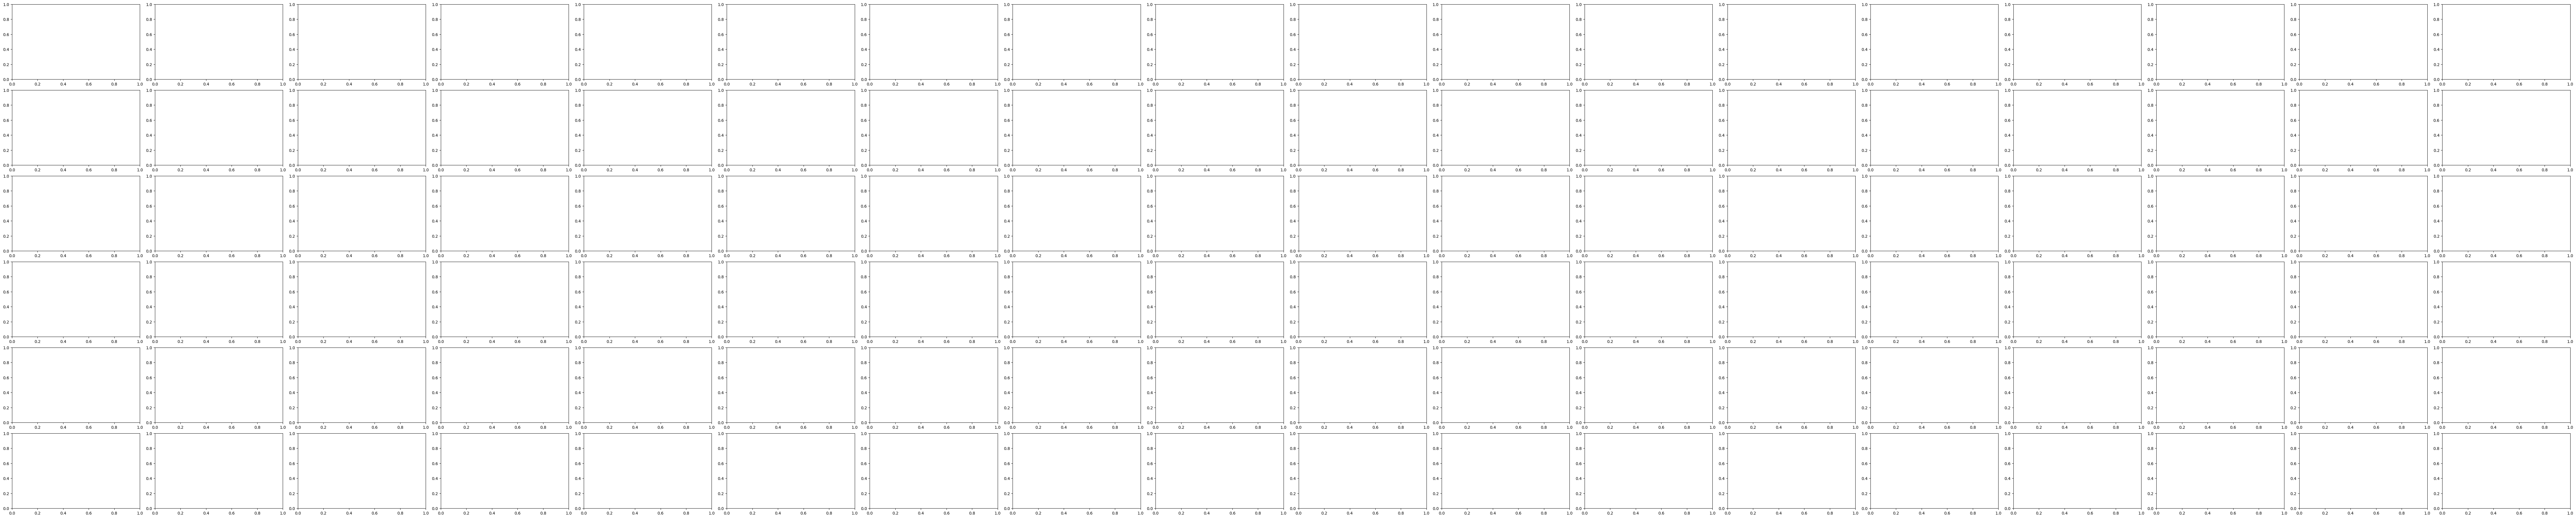

In [14]:
MODEL.render_predictive_check(
    df=DF, prediction_df=prediction_df, posterior_predictive=posterior_predictive, encoder_dict=ENCODER_DICT
)

In [8]:
def _plot(
    self,
    df: pd.DataFrame,
    dfs: list[pd.DataFrame],
    threshold_df: pd.DataFrame,
    destination_path: str,
    N: int,
    m: int
):
    """ Setup pdf layout """
    combinations = self._make_combinations(df=df, columns=self.combination_columns)
    n_combinations = len(combinations)

    n_columns_per_response = 1 + len(dfs)

    n_fig_rows = 10
    n_fig_columns = n_columns_per_response * self.n_response

    n_pdf_pages = n_combinations // n_fig_rows
    if n_combinations % n_fig_rows: n_pdf_pages += 1
    logger.info("Rendering ...")

    """ Iterate over pdf pages """
    pdf = PdfPages(destination_path)
    combination_counter = 0

    for page in range(n_pdf_pages):
        n_rows_current_page = min(
            n_fig_rows,
            n_combinations - page * n_fig_rows
        )

        fig, axes = plt.subplots(
            n_rows_current_page,
            n_fig_columns,
            figsize=(
                n_fig_columns * self.subplot_cell_width,
                n_rows_current_page * self.subplot_cell_height
            ),
            constrained_layout=True,
            squeeze=False
        )

        """ Iterate over combinations """
        for i in range(n_rows_current_page):
            curr_combination = combinations[combination_counter]

            """ Filter dataframe based on current combination """
            df_ind = df[self.combination_columns].apply(tuple, axis=1).isin([curr_combination])
            curr_df = df[df_ind].reset_index(drop=True).copy()

            th_ind = threshold_df[self.combination_columns].apply(tuple, axis=1).isin([curr_combination])
            curr_th_df = threshold_df[th_ind].reset_index(drop=True).copy()
            curr_ths = curr_th_df[self.response].values[0]

            """ Iterate over responses """
            j = 0
            for r, response in enumerate(self.response):
                """ Plots: Scatter Plot """
                ax = axes[i, j]
                sns.scatterplot(data=curr_df, x=self.intensity, y=response, color=self.response_colors[r], ax=ax)

                if j == 1:
                    ax.legend(loc="upper right")

                ax.set_title("Real Data - " + response)

                j += 1

                for sim_ind, curr_sim in enumerate(dfs):
                    curr_sim = curr_sim.copy()
                    curr_sim_ind = curr_sim[self.combination_columns].apply(tuple, axis=1).isin([curr_combination])
                    curr_sim = curr_sim[curr_sim_ind].reset_index(drop=True).copy()

                    ax = axes[i, j]
                    sns.scatterplot(data=curr_sim, x=self.intensity, y=response, color=self.response_colors[r], ax=ax)
                    ax.axvline(curr_ths[r], color="black", label="True Threshold")
                    ax.set_title(f"{N} Pulses, {m} Reps")

                    if not sim_ind:
                        ax.legend(loc="upper right")

                    j += 1

            combination_counter += 1

        pdf.savefig(fig)
        plt.close()

    pdf.close()
    plt.show()

    logger.info(f"Saved to {destination_path}")
    return


In [12]:
combinations = MODEL._make_combinations(df=DF, columns=MODEL.combination_columns)
combinations = [list(c[::-1]) for c in combinations]

df1 = DF[MODEL.combination_columns].drop_duplicates().reset_index(drop=True)
prefix = "strategy"
prefix2 = "comparison"

N_space = [40, 64, 72]
m_space = [1, 4, 8]
n_draws = 1

dfs = []
threshold_dfs = []

for draw_ind in range(n_draws):
    curr_draw_threshold_true = np.array(POSTERIOR_SAMPLES[site.a][draw_ind, ...])
    curr_draw_threshold_true = curr_draw_threshold_true[None, ...]

    threshold_df = df1.copy()
    threshold_df[MODEL.response] = 0

    for c in combinations:
        ind = threshold_df[MODEL.combination_columns[::-1]].apply(tuple, axis=1).isin([tuple(c)])
        threshold_df.loc[ind, MODEL.response] = curr_draw_threshold_true[0, *c, :]

    for m_ind, m in enumerate(m_space):
        for N_ind, N in enumerate(N_space):
            logger.info(f"draw:{draw_ind}, m:{m}, N:{N}")
            subdir = f"reps{m:02}_N{N:02}"

            N_eff = N // m
            df2 = pd.DataFrame(np.linspace(30, 70, N_eff), columns=[MODEL.intensity])
            df = df1.merge(df2, how="cross")
            df = pd.concat([df] * m, ignore_index=True).reset_index(drop=True)

            ppd = MODEL.predict(df=df, posterior_samples=POSTERIOR_SAMPLES)
            df[MODEL.response] = ppd[site.obs][draw_ind, ...]

            dest = os.path.join(CONFIG.BUILD_DIR, prefix, prefix2, f"reps{m:02}_N{N:02}.pdf")
            _plot(self=MODEL, df=DF, dfs=[df], threshold_df=threshold_df, destination_path=dest, N=N, m=m)


2023-09-22 16:25:20,295 - __main__ - INFO - draw:0, m:1, N:40


2023-09-22 16:25:22,793 - hbmep.utils.utils - INFO - func:predict took: 2.50 sec
2023-09-22 16:25:22,799 - __main__ - INFO - Rendering ...
2023-09-22 16:25:26,571 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/strategy/comparison/reps01_N40.pdf
2023-09-22 16:25:26,572 - __main__ - INFO - draw:0, m:1, N:64
2023-09-22 16:25:30,307 - hbmep.utils.utils - INFO - func:predict took: 3.73 sec
2023-09-22 16:25:30,312 - __main__ - INFO - Rendering ...
2023-09-22 16:25:33,785 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/strategy/comparison/reps01_N64.pdf
2023-09-22 16:25:33,785 - __main__ - INFO - draw:0, m:1, N:72
2023-09-22 16:25:37,927 - hbmep.utils.utils - INFO - func:predict took: 4.14 sec
2023-09-22 16:25:37,933 - __main__ - INFO - Rendering ...
2023-09-22 16:25:41,390 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/strategy/comparison/reps01_N72.pdf
2023-09-22 16:25:4

In [ ]:
df1 = DF[MODEL.combination_columns].drop_duplicates().reset_index(drop=True)
prefix = "strategy"

N_space = [16, 24, 32, 40, 48, 56, 64, 72, ]
m_space = [1, 2, 4, 8, 16]
n_draws = 10

# N_space = [3, 6]
# m_space = [1, 2, 3]
# n_draws = 4

# N_space = [5, 10, 15]
# m_space = [1, 2]

threshold = None
threshold_true = None

for draw_ind in range(n_draws):
    curr_draw_threshold = None

    curr_draw_threshold_true = np.array(POSTERIOR_SAMPLES[site.a][draw_ind, ...])
    curr_draw_threshold_true = curr_draw_threshold_true[None, ...]

    if threshold_true is None:
        threshold_true = curr_draw_threshold_true
    else:
        threshold_true = np.concatenate([threshold_true, curr_draw_threshold_true], axis=0)

    for m_ind, m in enumerate(m_space):
        curr_threshold = None

        for N_ind, N in enumerate(N_space):
            logger.info(f"draw:{draw_ind}, m:{m}, N:{N}")
            draw_dir = f"draw{draw_ind:02}"
            subdir = f"reps{m:02}_N{N:02}"

            N_eff = N // m
            df2 = pd.DataFrame(np.linspace(0, 100, N_eff), columns=[MODEL.intensity])
            df = df1.merge(df2, how="cross")
            df = pd.concat([df] * m, ignore_index=True).reset_index(drop=True)

            ppd = MODEL.predict(df=df, posterior_samples=POSTERIOR_SAMPLES)
            df[MODEL.response] = ppd[site.obs][draw_ind, ...]

            """ Build model """
            config = Config(toml_path=toml_path)
            config.BUILD_DIR = os.path.join(CONFIG.BUILD_DIR, prefix, draw_dir, subdir)
            model = HierarchicalBayesianModel(config=config)
            model._make_dir(dir=model.build_dir)

            """ Fit """
            mcmc, posterior_samples = model.run_inference(df=df)

            """ Predict """
            prediction_df = model.make_prediction_dataset(df=df)
            ppd = model.predict(df=prediction_df, posterior_samples=posterior_samples)

            """ Plot """
            model.render_recruitment_curves(df=df, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=ppd)
            model.render_predictive_check(df=df, prediction_df=prediction_df, posterior_predictive=ppd)

            """ Threshold """
            th = np.array(posterior_samples[site.a]).mean(axis=0)
            th = th[None, ...]

            if curr_threshold is None:
                curr_threshold = th
            else:
                curr_threshold = np.concatenate([curr_threshold, th], axis=0)

        curr_threshold = curr_threshold[None, ...]

        if curr_draw_threshold is None:
            curr_draw_threshold = curr_threshold
        else:
            curr_draw_threshold = np.concatenate([curr_draw_threshold, curr_threshold], axis=0)

    curr_draw_threshold = curr_draw_threshold[None, ...]

    if threshold is None:
        threshold = curr_draw_threshold
    else:
        threshold = np.concatenate([threshold, curr_draw_threshold], axis=0)



In [219]:
dest = os.path.join(MODEL.build_dir, prefix, "threshold.npy")
np.save(dest, threshold)

dest = os.path.join(MODEL.build_dir, prefix, "threshold_true.npy")
np.save(dest, threshold_true)

In [220]:
src = os.path.join(MODEL.build_dir, prefix, "threshold.npy")
th_ = np.load(src)

(th_ == threshold).all()

True

In [221]:
src = os.path.join(MODEL.build_dir, prefix, "threshold_true.npy")
th_true = np.load(src)

(th_true == threshold_true).all()

True

In [268]:
prefix = "strategy"

src = os.path.join(MODEL.build_dir, prefix, "threshold.npy")
threshold = np.load(src)

src = os.path.join(MODEL.build_dir, prefix, "threshold_true.npy")
threshold_true = np.load(src)


In [269]:
threshold.shape

(5, 5, 8, 6, 2, 6)

In [270]:
threshold_true.shape

(6, 6, 2, 6)

In [271]:
N_space = [16, 24, 32, 40, 48, 56, 64, 72, ]
m_space = [1, 2, 4, 8, 16]

In [272]:
print(len(m_space), len(N_space))

5 8


In [273]:
threshold_true[:-1, ...].shape

(5, 6, 2, 6)

In [274]:
y = threshold
y_true = threshold_true[:-1, ...]

print(y.shape, y_true.shape)

(5, 5, 8, 6, 2, 6) (5, 6, 2, 6)


In [275]:
a = POSTERIOR_SAMPLES[site.a].mean(axis=0)
a.shape

combinations = MODEL._make_combinations(df=DF, columns=MODEL.combination_columns)
combinations = [list(c[::-1]) for c in combinations]

y_mask = np.full(y.shape, True)
y_mask[:, :, :, *map(list, zip(*combinations))] = False
print(y_mask.shape)

y_true_mask = np.full(y_true.shape, True)
y_true_mask[:, *map(list, zip(*combinations))] = False
print(y_true_mask.shape)

(5, 5, 8, 6, 2, 6)
(5, 6, 2, 6)


In [276]:
for i in range(5):
    for j in range(5):
        for k in range(8):
            assert (~y_mask[i, j, k, ...]).sum() == len(combinations) * MODEL.n_response
            assert (y_mask[i, j, k, ...] == y_mask[0, 0, 0, ...]).all()

for i in range(5):
    assert (~y_true_mask[i, ...]).sum() == len(combinations) * MODEL.n_response
    assert (y_true_mask[i, ...] == y_true_mask[0, ...]).all()

In [277]:
# # Additional masks
# additional_masks = [
#     (2, 1, 0),
#     (1, 1, 1),
#     (0, 1, 2),
#     (1, 1, 2),
#     (2, 1, 2),
#     (4, 1, 2),
#     (3, 1, 2),
#     (1, 1, 3),
#     (1, 1, 4),
#     (0, 1, 5),
#     (4, 1, 5)
# ]

# y_mask[:, :, :, *map(list, zip(*additional_masks))] = True
# y_true_mask[:, *map(list, zip(*additional_masks))] = True


In [278]:
y = np.ma.array(y, mask=y_mask)
y_true = np.ma.array(y_true, mask=y_true_mask)

print(y.shape, y_true.shape)

(5, 5, 8, 6, 2, 6) (5, 6, 2, 6)


In [279]:
mae = np.ma.abs(y - y_true[:, None, None, ...])
mae.shape

(5, 5, 8, 6, 2, 6)

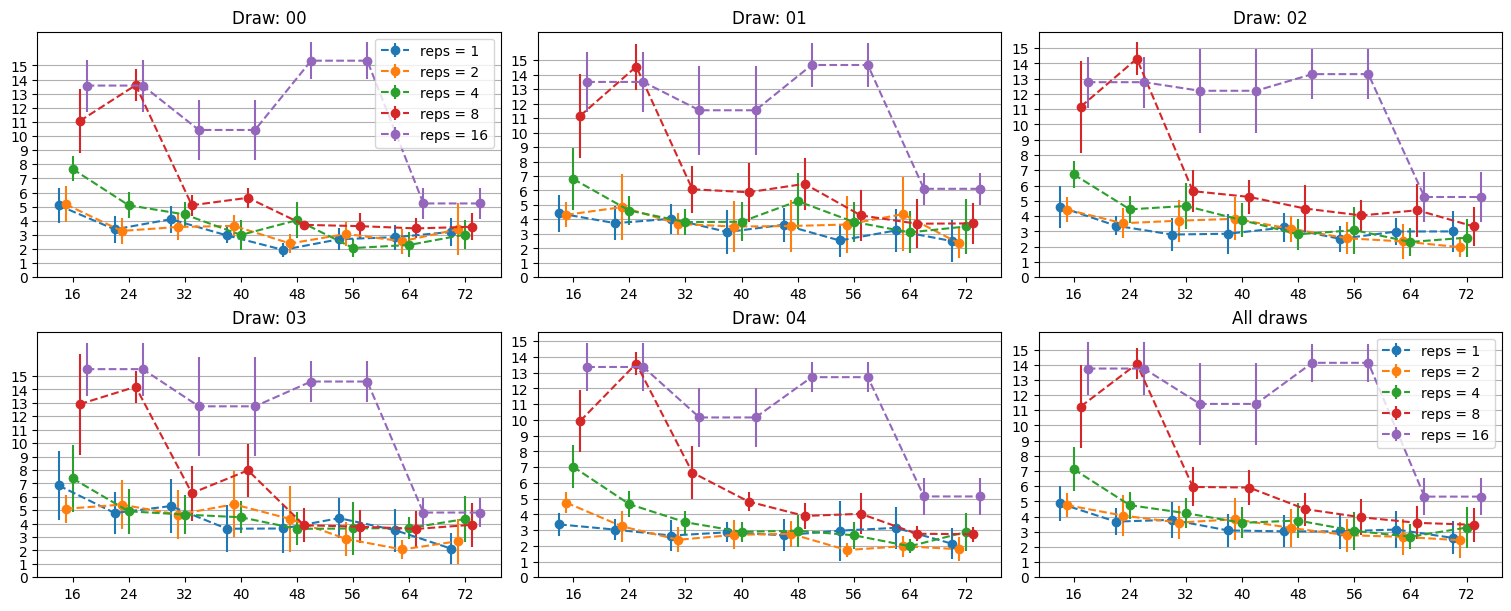

In [280]:
confidence = .95
n_draws = y.shape[0]
jitter = np.array([-4, -2, 0, 2, 4]) / 2

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), constrained_layout=True, squeeze=False)

i = 0
for draw_ind in range(n_draws):
    ax = axes[i // ncols, i % ncols]

    curr_mae = mae[draw_ind, ...]
    curr_mae = curr_mae.mean(axis=-1)
    curr_mae_mean = curr_mae.mean(axis=(-1, -2))
    curr_mae_se = stats.sem(curr_mae, axis=(-1, -2))

    for m_ind, m in enumerate(m_space):
        ax.errorbar(
            x=N_space + jitter[m_ind],
            y=curr_mae_mean[m_ind, ...],
            fmt="o",
            linestyle="--",
            yerr=curr_mae_se[m_ind, ...],
            label=f"reps = {m:1}"
        )
    ax.set_xticks(N_space)
    ax.set_title(f"Draw: {draw_ind:02}")
    if i == 0:
        ax.legend()
    ax.grid(axis="y")
    ax.set_yticks(np.arange(0, 16, 1))
    # ax.set_yscale("log")
    i += 1

ax = axes[-1, -1]
curr_mae = mae.mean(axis=-1).mean(axis=0)
curr_mae_mean = curr_mae.mean(axis=(-1, -2))
curr_mae_se = stats.sem(curr_mae, axis=(-1, -2))

for m_ind, m in enumerate(m_space):
    ax.errorbar(
        x=N_space + jitter[m_ind],
        y=curr_mae_mean[m_ind, ...],
        fmt="o",
        linestyle="--",
        yerr=curr_mae_se[m_ind, ...],
        label=f"reps = {m:1}"
    )
ax.set_xticks(N_space)
ax.set_title(f"All draws")
ax.legend()
ax.set_yticks(np.arange(0, 16, 1))
ax.grid(axis="y")
# ax.set_yscale("log")


In [281]:
curr_mae = mae.mean(axis=-1).mean(axis=0)

compare_ind = 3
t = (curr_mae[compare_ind, ...] - curr_mae[0, ...])
t = t.reshape(t.shape[0], -1)
t.shape

p_values = []
for i in range(len(N_space)):
    curr_t = t[i, ...]
    curr_t = curr_t[curr_t.mask == False]
    curr_t = curr_t.data
    p = stats.ttest_1samp(curr_t, popmean=0, alternative="greater")
    p_values.append(p.pvalue)

p_values = np.array(p_values)

print(f"reps:{m_space[compare_ind]} vs reps:1 (one-sided)")
arr_to_print = np.round(p_values, 3).tolist()
arr_to_print = list(map(list, zip(N_space, arr_to_print)))
arr_to_print = ["N"+": ".join([str(num) for num in row]) for row in arr_to_print]

for elem in arr_to_print: print(elem)
print("")





reps:8 vs reps:1 (one-sided)
N16: 0.007
N24: 0.0
N32: 0.002
N40: 0.001
N48: 0.0
N56: 0.004
N64: 0.078
N72: 0.005



In [282]:
p_values_round = np.round(p_values, 3)
p_values_round

stars = []
for pval in p_values:
    if pval < 0.001:
        stars.append("***")
    elif pval < 0.01:
        stars.append("**")
    elif pval < 0.05:
        stars.append("*")
    else:
        stars.append("")

In [285]:
p_values

array([0.00711593, 0.0002715 , 0.00179328, 0.00099418, 0.00013815,
       0.00371526, 0.07820776, 0.00513278])

In [283]:
p_values_labs = [
    str(pval) + star for (pval, star) in zip(p_values_round, stars)
]
p_values_labs

['0.007**',
 '0.0***',
 '0.002**',
 '0.001***',
 '0.0***',
 '0.004**',
 '0.078',
 '0.005**']

Text(0, 0.5, 'Mean Absolute Error (6 Participants)')

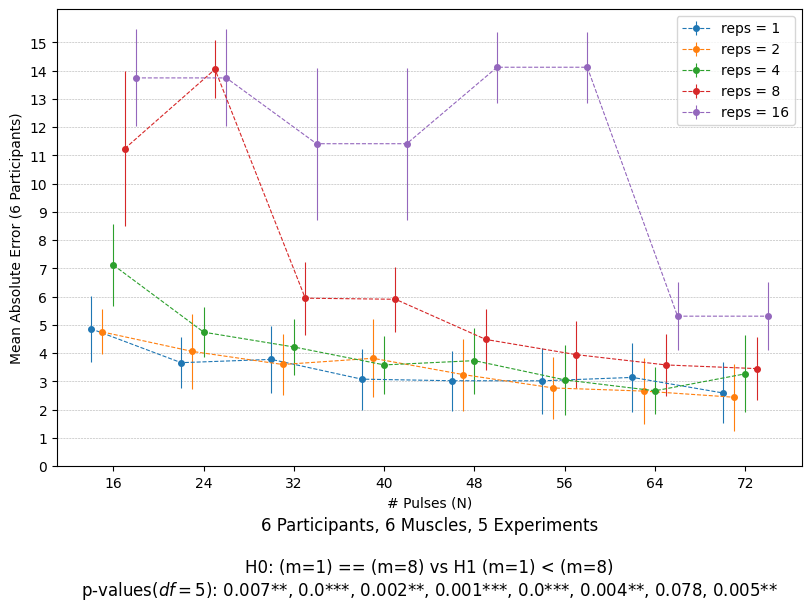

In [284]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

curr_mae = mae.mean(axis=-1).mean(axis=0)
curr_mae_mean = curr_mae.mean(axis=(-1, -2))
curr_mae_se = stats.sem(curr_mae, axis=(-1, -2))

for m_ind, m in enumerate(m_space):
    ax.errorbar(
        x=N_space + jitter[m_ind],
        y=curr_mae_mean[m_ind, ...],
        fmt="o",
        linestyle="--",
        yerr=curr_mae_se[m_ind, ...],
        label=f"reps = {m:1}",
        linewidth=.8,
        ms=4
    )

ax.set_xticks(N_space)
ax.set_title(
    f'6 Participants, 6 Muscles, 5 Experiments\n\nH0: (m=1) == (m=8) vs H1 (m=1) < (m=8)\np-values$(df = 5)$: {", ".join(p_values_labs)}',
    y=-0.3
)

ax.legend()
ax.set_yticks(np.arange(0, 16, 1))
ax.grid(axis="y", linestyle='--', linewidth=.4)
ax.set_xlabel("# Pulses (N)")
ax.set_ylabel("Mean Absolute Error (6 Participants)")
